In [1]:
import sys

sys.path.append("..")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import h5py
import timm
import torch
import torch.nn as nn
from sklearn.model_selection import StratifiedKFold
from timm import create_model
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from transformers.optimization import (
    get_linear_schedule_with_warmup,
    get_cosine_schedule_with_warmup,
)
from scipy.stats import norm
import torch.nn.functional as F
from pathlib import Path
from torch.utils.data import DataLoader
import os
from fastprogress.fastprogress import master_bar, progress_bar
from fastai.vision.all import L, unsqueeze
from timm.data.mixup import Mixup
from timm.loss import (
    LabelSmoothingCrossEntropy,
    BinaryCrossEntropy,
    SoftTargetCrossEntropy,
)
import random
from einops import rearrange
import gc
from fastai.vision.all import BCEWithLogitsLossFlat

import warnings
warnings.filterwarnings("ignore", category=np.ComplexWarning)

In [2]:
def get_snr(left, right, df):
    df_ = pd.concat([df.query(f"snr>{left} & snr<{right}"), df.query("snr==0")])
    return df_


def generate_report(df, p, fn):
    pred = torch.sigmoid(p).cpu().numpy().reshape(-1)
    val_df_eval = df.copy()
    val_df_eval["pred"] = pred
    val_df_eval.to_csv(f"{fn}_oof.csv")

    roc_100 = roc_auc_score(val_df_eval["target"], val_df_eval["pred"])
    roc_50_100 = roc_auc_score(
        get_snr(0, 100, val_df_eval)["target"], get_snr(0, 100, val_df_eval)["pred"]
    )
    roc_0_50 = roc_auc_score(
        get_snr(0, 50, val_df_eval)["target"], get_snr(0, 50, val_df_eval)["pred"]
    )
    roc_0_40 = roc_auc_score(
        get_snr(0, 40, val_df_eval)["target"], get_snr(0, 40, val_df_eval)["pred"]
    )
    roc_0_30 = roc_auc_score(
        get_snr(0, 30, val_df_eval)["target"], get_snr(0, 30, val_df_eval)["pred"]
    )

    roc_0_20 = roc_auc_score(
        get_snr(0, 20, val_df_eval)["target"], get_snr(0, 20, val_df_eval)["pred"]
    )

    return {
        "roc_all": roc_100,
        "roc_50_100": roc_50_100,
        "roc_0_50": roc_0_50,
        "roc_0_40": roc_0_40,
        "roc_0_30": roc_0_30,
        "roc_0_20": roc_0_20,
    }

In [3]:
class SaveModel:
    def __init__(self, folder, exp_name, best=np.inf):
        self.best = best
        self.folder = Path(folder) / f"{exp_name}.pth"

    def __call__(self, score, model, epoch):
        if score < self.best:
            self.best = score
            print(f"Better model found at epoch {epoch} with value: {self.best}.")
            torch.save(model.state_dict(), self.folder)


class SaveModelMetric:
    def __init__(self, folder, exp_name, best=-np.inf):
        self.best = best
        self.folder = Path(folder) / f"{exp_name}.pth"

    def __call__(self, score, model, epoch):
        if score > self.best:
            self.best = score
            print(f"Better model found at epoch {epoch} with value: {self.best}.")
            torch.save(model.state_dict(), self.folder)


class SaveModelEpoch:
    def __init__(self, folder, exp_name, best=-np.inf):
        self.best = best
        self.folder = Path(folder)
        self.exp_name = exp_name

    def __call__(self, score, model, epoch):
        self.best = score
        print(f"Better model found at epoch {epoch} with value: {self.best}.")
        torch.save(model.state_dict(), f"{self.folder/self.exp_name}_{epoch}.pth")


def custom_auc_score(p, gt):
    return roc_auc_score(gt.cpu().numpy(),  torch.sigmoid(p).cpu().numpy().reshape(-1))


def fit_mixup(
    epochs,
    model,
    train_dl,
    valid_dl,
    loss_fn,
    opt,
    metric,
    val_df,
    folder="models",
    exp_name="exp_00",
    device=None,
    sched=None,
    mixup_=False,
    save_md=SaveModelEpoch,
):
    if device is None:
        device = (
            torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        )

    os.makedirs(folder, exist_ok=True)
    loss_fn_trn = loss_fn
    if mixup_:
        mixup = Mixup(num_classes=2, mixup_alpha=0.4, prob=0.8)
        loss_fn_trn = BinaryCrossEntropy()
    mb = master_bar(range(epochs))

    mb.write(
        [
            "epoch",
            "train_loss",
            "valid_loss",
            "val_metric",
            "roc_all",
            "roc_50_100",
            "roc_0_50",
            "roc_0_40",
            "roc_0_30",
            "roc_0_20",
        ],
        table=True,
    )
    model.to(device)  # we have to put our model on gpu
    #scaler = torch.cuda.amp.GradScaler()  # this for half precision training
    save_md = save_md(folder, exp_name)

    for i in mb:  # iterating  epoch
        trn_loss, val_loss = 0.0, 0.0
        trn_n, val_n = len(train_dl.dataset), len(valid_dl.dataset)
        model.train()  # set model for training
        for (xb, yb) in progress_bar(train_dl, parent=mb):
            xb, yb = xb.to(device), yb.to(device)  # putting batches to device
            if mixup_:
                xb, yb = mixup(xb, yb)
           
            out = model(xb)  # forward pass
            loss = loss_fn_trn(out, yb)  # calulation loss

            trn_loss += loss.item()
            #print(loss.item())
            opt.zero_grad()  # zeroing optimizer
            loss.backward()  # backward
            opt.step()  # optimzers step
            if sched is not None:
                sched.step()  # scuedular step

        trn_loss /= mb.child.total

        # putting model in eval mode
        model.eval()
        gt = []
        pred = []
        # after epooch is done we can run a validation dataloder and see how are doing
        with torch.no_grad():
            for (xb, yb) in progress_bar(valid_dl, parent=mb):
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                loss = loss_fn(out, yb)
                val_loss += loss.item()

                gt.append(yb.detach())
                pred.append(out.detach())
        # calculating metric
        metric_ = metric(torch.cat(pred), torch.cat(gt))
        # saving model if necessary
        save_md(metric_, model, i)
        val_loss /= mb.child.total
        dict_res = generate_report(val_df, torch.cat(pred), f"{folder}/{exp_name}_{i}")

        pd.DataFrame(
            {
                "trn_loss": [trn_loss],
                "val_loss": [val_loss],
                "metric": [metric_],
                "roc_all": [dict_res["roc_all"]],
                "roc_50_100": [dict_res["roc_50_100"]],
                "roc_0_50": [dict_res["roc_0_50"]],
                "roc_0_40": [dict_res["roc_0_40"]],
                "roc_0_30": [dict_res["roc_0_30"]],
                "roc_0_20": [dict_res["roc_0_20"]],
            }
        ).to_csv(f"{folder}/{exp_name}_{i}.csv", index=False)
        mb.write(
            [
                i,
                f"{trn_loss:.6f}",
                f"{val_loss:.6f}",
                f"{metric_:.6f}",
                f"{dict_res['roc_all']:.6f}",
                f"{dict_res['roc_50_100']:.6f}",
                f"{dict_res['roc_0_50']:.6f}",
                f"{dict_res['roc_0_40']:.6f}",
                f"{dict_res['roc_0_30']:.6f}",
                f"{dict_res['roc_0_20']:.6f}",
            ],
            table=True,
        )
    print("Training done")
    # loading the best checkpoint

In [4]:
def dataload(filepath):
    astime = np.full([2, 360, 5760], np.nan, dtype=np.float32)
    with h5py.File(filepath, "r") as f:
        fid, _ = os.path.splitext(os.path.split(filepath)[1])
        HT = (
            (np.asarray(f[fid]["H1"]["timestamps_GPS"]) / 1800).round().astype(np.int64)
        )
        LT = (
            (np.asarray(f[fid]["L1"]["timestamps_GPS"]) / 1800).round().astype(np.int64)
        )
        MIN = min(HT.min(), LT.min())
        HT -= MIN
        LT -= MIN
        H1 = normalize(np.asarray(f[fid]["H1"]["SFTs"], np.complex128))
        valid = HT < 5760
        astime[0][:, HT[valid]] = H1[:, valid]
        L1 = normalize(np.asarray(f[fid]["L1"]["SFTs"], np.complex128))
        valid = LT < 5760
        astime[1][:, LT[valid]] = L1[:, valid]
    gc.collect()
    return fid, astime, H1.mean(), L1.mean()

def normalize(X):
    X = (X[..., None].view(X.real.dtype) ** 2).sum(-1)
    POS = int(X.size * 0.99903)
    EXP = norm.ppf((POS + 0.4) / (X.size + 0.215))
    scale = np.partition(X.flatten(), POS, -1)[POS]
    X /= scale / EXP.astype(scale.dtype) ** 2
    return X

def preprocess(num, input, H1, L1):
    input = torch.from_numpy(input).to("cpu", non_blocking=True)
    rescale = torch.tensor([[H1, L1]]).to("cpu", non_blocking=True)
    tta = (
        torch.randn([num, *input.shape, 2], device=input.device, dtype=torch.float32)
        .square_()
        .sum(-1)
    )
    tta *= rescale[..., None, None] / 2
    valid = ~torch.isnan(input)
    tta[:, valid] = input[valid].float()
    return tta[0]

In [5]:
class DataV0:
    """
    dataset = Dataset(data_type, df)

    img, y = dataset[i]
      img (np.float32): 2 x 360 x 128
      y (np.float32): label 0 or 1
    """

    def __init__(self, df, tfms=False):
        self.df = df
        self.tfms = tfms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        """
        i (int): get ith data
        """
        r = self.df.iloc[i]
        y = np.float32(r.target)
        #fid, img, H1, L1 = dataload(r.id)
        #img =  np.array(preprocess(1, img, H1, L1))
        
        img = np.array(torch.load(r.id)).astype('float32')

        if self.tfms:
            if np.random.rand() <= 0.5:  # horizontal flip
                img = np.flip(img, axis=1).copy()
            if np.random.rand() <= 0.5:  # vertical flip
                img = np.flip(img, axis=2).copy()
            if np.random.rand() <= 0.5:  # vertical shift
                img = np.roll(img, np.random.randint(low=0, high=img.shape[1]), axis=1)

        return img,  y
    

class LargeKernel_debias(nn.Conv2d):
    def forward(self, input: torch.Tensor):
        finput = input.flatten(0, 1)[:, None]
        target = abs(self.weight)
        target = target / target.sum((-1, -2), True)
        joined_kernel = torch.cat([self.weight, target], 0)
        reals = target.new_zeros(
            [1, 1] + [s + p * 2 for p, s in zip(self.padding, input.shape[-2:])]
        )
        reals[
            [slice(None)] * 2
            + [slice(p, -p) if p != 0 else slice(None) for p in self.padding]
        ].fill_(1)
        output, power = torch.nn.functional.conv2d(
            finput, joined_kernel, padding=self.padding
        ).chunk(2, 1)
        ratio = torch.div(*torch.nn.functional.conv2d(reals, joined_kernel).chunk(2, 1))
        output = output.sub(power.mul(ratio))
        return output.unflatten(0, input.shape[:2]).flatten(1, 2)
    

def get_model(path):
    model = create_model(
        "tf_efficientnetv2_b0",
        in_chans=32,
        num_classes=2,
    )
    state_dict = torch.load(path)
    C, _, H, W = state_dict["conv_stem.2.weight"].shape
    print(C, _, H, W)
    model.conv_stem = nn.Sequential(
        nn.Identity(),
        nn.Identity(),
        LargeKernel_debias(1, C, [H, W], 1, [H // 2, W // 2], 1, 1, False),
        model.conv_stem,
    )
    model.load_state_dict(state_dict)
    return model.conv_stem[:3]

class LargeKernelModel(nn.Module):
    def __init__(self, CFG):
        super().__init__()
        self.head = get_model('../DEBIAS_SUB/model_best.pth')
        self.enc = create_model(
                    CFG.model_name,
                    pretrained=True,
                    num_classes=CFG.num_classes,
                    in_chans=32,
                )
        
    def forward(self, x):
        x = self.head(x)
        return self.enc(x)

In [6]:
class CFG:
    bs = 26
    nw = 8
    model_name = "convnext_large_in22k"
    lr = 1e-4
    wd = 1e-4
    epoch = 5
    warmup_pct = 0.1
    num_classes = 1
    dropout_rate = 0.3
    folder = "EXP_50_00_denoise_V5_PSD"
    mixup=False
    split_voldf = Path("../data/SPLITS/V_20")
    exp_name = f"{folder}_{model_name}_{split_voldf.stem}_{mixup}_POS"

In [7]:

trn_df = pd.read_csv(CFG.split_voldf/'trn_df.csv')
val_df = pd.read_csv(CFG.split_voldf/'val_df.csv')
submit = pd.read_csv('../data/SUBS/ENS_44.csv')
#pos = ['008b91c55','00bce5685','00f226552','012992291','015bf0213','017a7c7f1','0195324d2','01cb9865c','01dc5af02','023aebec4','028b6615d','02c2e5de1','0302d47d0','030658180','0354a13e2','03717ca39','04592c3d1','047fb9ed5','051895cd1','05cad0ed3','05eda6f5a','0611d3c27','0639bd69d','0675028e4','06ac9d3ea','077a11239','077a57010','07b2073db','07cd0847f','07dd7e0e2','08f6988f4','092c9af35','094687e08','0a2e0807c','0a61f1932','0a9780441','0a9def5f6','0ae4c93c8','0ae892b99','0afa0bb1b','0bce75cc0','0bfb2a22e','0c7f63a4c','0cac0b665','0d0fb754f','0d16c6139','0d70d7ce1','0d9fd6c93','0dcfb8530','0dfe6acb4','0e168818a','0e26a554b','0e33ca7db','0eaafb22f','0ebff2780','0f9dd9eca','0fefc4fd9','1081950a3','11c6c76ab','1242a70e8','1286e574f','12b3ae845','12d8eed90','12db0b252','13731679d','137a2ed27','137d4d41b','13ab0a0b2','13c0417d6','13c184cdc','13ddf3c72','147fbd0fe','14d7c9498','14dfefcd5','14eb4a20c','15149b585','154e3c957','15785900e','15b0fd78b','15ecfbf90','15fc931ea','161dff33f','162395d96','163f2d88e','166baf13f','166ffe397','168f2a36c','16a661528','1764d7bf0','17ecd00b9','180d34e52','180f77ac8','183510397','18448da35','18d56acf1','193667fcf','1948c446d','1979dbea3','19c4818b5','19cf5d868','1a6246e1a','1a695b048','1aa71d63a','1abc53c78','1abdbf772','1ad1b366d','1aea74b40','1b7608cf7','1bdcfd1e6','1cb847682','1ce108de4','1d986a4b5','1df3960ac','1e66dc097','1ed98b2c2','1f4dd9252','1f9bb71c0','20612b3e4','20d6d3d11','20e1dbc67','210c5f6a1','211108cc0','218b75976','21dd6365d','221b920a4','2221e08b4','2232ffe30','22b61b7b3','22c61fa16','234e172c0','23c5d3107','23d70e5d1','23d90d609','240789d04','243845761','248d86603','249099ad6','2498595ac','24b4174cb','25671a512','257264706','25b483fa0','25cc60c9b','26ca57eba','275a2d879','2761e4bad','277238c02','289b9b1d8','28f679138','291c8006b','2955a55b1','29873c606','29f3d1ed5','2a0159541','2a12adffe','2a180c12a','2a78ef0cd','2a870f928','2abd229bc','2ae002c3f','2aea19b04','2bb864b08','2ca75fabd','2cbdeb983','2cbe330e0','2ceb94002','2d207c125','2d2275bb5','2d4b3758d','2d57c9399','2d5db8379','2d757d2c1','2d8486121','2e5af1d8b','2e86815e1','2e9466aee','2ec06617e','2ec2db48d','2f5dfb161','2fc00284e','2fe5f1717','2fe8795d8','30218f6ba','3022e8994','30240e8a5','302a9cc68','306bdc5c1','309c1cc9e','30c29d4ee','3109af837','3190f5826','31a1ff060','31ffa6934','322046c4d','3242d94d2','3245cf936','326a66010','3279f4bba','327d89e99','32d5c7384','32e593923','3323888e7','334680bd1','336ed74d4','337b82964','338088eee','33abc2840','33ac02361','34365c566','3443e104d','3485ed239','34d9740b9','3507e1515','356e630ce','35a5ef7d2','35a67c429','35e7353b3','36625a7db','3742aa18c','3753e999c','376ffab2d','37bae074b','381a9af29','3885d0e1a','388d00912','38994676c','38b2510ec','39a264f07','39add4593','3a94e8b84','3abcdaf6a','3ac230af8','3ae232a65','3b54fbb0b','3b6e7f0ac','3c1fe0fb6','3c84aad9a','3caac79b1','3cda37254','3cff3d1df','3db99e7cf','3dc645474','3dccf2e04','3e3f4c2e5','3e4a3c65a','3e4b4a631','3e503b700','3e8a698ca','3ed8f820b','3f5849e72','3f5be5bf5','3fa023578','3feac2d37','4006adb1a','40df3665f','40e118e70','41067c0bd','412c5e57f','41e5f7426','41f4bd1b3','42313a825','4247e30cf','426cadd53','427e1391e','42ca943d0','42efccabf','4337094c3','435465a6a','43ab3acba','43fb14080','4417a60ae','44c13833b','450f0b42f','45b549521','45e8578bc','4641e706a','465de42ff','46684d694','46cab26bb','46ea07334','473adc567','473ef0b67','4751cd02c','4768dd659','478547418','47a217380','47e64ebe7','480eb7762','48589b9ca','485be1079','48ac8d5c4','494456b4c','49cc0b77a','49d9e7dad','4a095dc42','4a5e7564f','4a620e20d','4b1dc214e','4c41ba002','4c5343657','4ca82fcd5','4d0bba14e','4d9b509f0','4dff1cfb2','4e03f621d','4f306a341','4f6265cfb','4f69417cf','50456e78c','50851fe35','50865063c','50ab23095','50feb40ff','517f12b45','51f813b14','52186fb05','523d37990','529ad9fed','5302a5c1d','5329a429c','53320e6bc','53362e699','5348aa921','5376c9cac','5388e737d','53bc73f80','53c4b4b1a','53ead9e8f','53f254a5c','5434a1eee','546913595','55179b353','55465dae2','556ee9c40','5618591e4','562c9d013','56336430b','56b57039a','56e3a9c78','56edbe968','572ac63ea','57e146d20','58d8aeb84','59a6a4b02','59b1791b4','59f188a9f','5a36b5407','5ab02c27d','5b122cc22','5b3e96840','5b7871232','5b8a21b44','5bb4aa235','5bbd60669','5c7713b7a','5ccee0125','5cef1993d','5cf106611','5dc1bab81','5e12c0d48','5e4a83024','5f90f5bc9','5f99503fd','5f9a1ef53','5faac0b36','5ffd1f11a','60380ce6d','603dbb7b9','608c2d607','60b86e780','60e18e479','61183e510','611b863fd','615e4bcf6','615f76e28','616339a77','61682b309','61b9d669e','628f43ef0','62dc61c11','62e469f67','630d8cc86','632870895','634a9528f','63518bd39','63bd7e7de','63edc2e4f','63efe2c16','6478d9d02','649652bbd','64b4f83b6','64b8fa1fa','6509ebfa6','651668d15','651de73fa','65289fa27','657ae82b3','657ebf705','659945133','65dacb72d','65dbc156d','66e20bdbc','6753d332c','67c98515f','6862e262c','687891898','68d6e5e02','68ebd9148','69ad5230b','69f5bf408','6aa93b740','6b014dd4a','6b56645ec','6b610a30e','6b65bd089','6b6faf1da','6b7099148','6b8655c14','6bd915dd1','6be9fd24d','6c14a4f3f','6c3c3e3b4','6c7032492','6c735c1e4','6d24da6f2','6d6c10816','6d7d7ae6e','6dccc5fe9','6e4e39262','6e63e80b4','6ec60dc8f','6fb096f56','6feef7863','7013e82bb','709f52e60','70a9bab8e','711f82733','712a1e583','71e9a45de','720ed4c62','7265d9605','73281d4ef','7335f79ff','73ec484a3','741b6a3a3','745164304','7456ed1d3','749d5249c','752b5cf52','7537c3e7f','755d947a2','75ac44aff','7655b2d3c','76e40fc8a','7709f0194','7715b67f2','771f29ac3','779f7cdd7','77c3a6877','780936b0d','781ede24b','784cef59b','785001f55','785011ce6','78a3facc4','78c328627','78f2a09b1','793bc5ca2','793c2bc40','7971e3fa2','7982939f2','7a1eb66cd','7a4c3b959','7a7f1a9c1','7a9421439','7ad6a95c1','7b1f9f4a4','7bf732340','7c251f371','7c37fb90d','7e7192783','7e8a33986','7f343a951','7f18dcb24','7fb749b67','8008b5751','805264555','80c9d62f7','80f7a5168','818a4f930','81c8ae37f','81d93c6fa','81ed35f3d','82d25d2a7','835e95505','8365381ee','83684c02b','83873a300','846259c61','8485c991b','849cbfcbf','84a7327bc','84ed19a7d','856831ddf','861240b40','861b2119e','86531152e','867293db6','8707988b8','87136e3c4','8819b75c6','881ee1435','88bffad32','88e3a7747','88ec93a19','894a5a054','8972c5591','897d945ce','8992e892e','899f60a37','8a4830756','8aa5137a5','8ab48304e','8b48760a4','8ba318040','8c0471631','8c103dd7d','8c4642358','8c722d417','8c7d6c68a','8cdab6dfb','8cdef8adf','8ce510886','8d0873458','8daf59cf1','8de46bd52','8e6048ed6','8e7a9c60e','8e9e3c11e','8eb077696','8edd10d8c','8f41cb705','8fea9a7cb','901fde144','9048ae8d0','907ce79d9','908d06ba1','9145337f5','9186fe6d5','91b6b60bc','91f7fed7f','927dfd49a','92845e015','93143054e','9316bf46e','9326252a8','93dd663b6','93e150893','95fe6b82b','964f27e0b','96a527a7d','9717b6d76','9727a02cc','983a9616f','98b8bf99d','b21dac14c','9951f9a1e','996b2b55e','99a8c8e67','99b1f29c4','99c8b63f1','9a1f34301','9b1c22a2f','9b3968afa','b8f8ba393','9b5b33610','9b8de9d8e','9b9d80b0e','9c02351ec','9c02b193b','9c060f0f4','9c59d4cc1','9c6c67747','9c816769d','9d13239ac','9d37c620d','9d58201e6','9d7676848','9e49c9fe4','9e5143dd1','9f1b0e62e','9f5acbd94','9f635d10d','a00adfc84','a01663464','a06ce46d7','a0e9925da','a12b21258','a13581e65','a14506109','a18613f2c','a18ae6248','a22464405','a251743b4','a2a0c2602','a2e7ee5ac','a3349d5b1','a356ae34a','a411ad130','a42f5bd64','a438c6cfc','a448b8a13','a47c5095a','a51035b48','a516aa9d6','a5c39d5fe','a733a9c7e','a77da0f78','a7a6015e0','a7b12149e','a85fc17f2','a8aaa9755','a8fefe2a5','a91b62430','a5c65d974','a62f12b24','a67f981fd','a2f07fb2f','a18bc84df','a1b093860','a93def817','a9952664f','eec309fff','a9b4113f2','a9d495532','aa6b261d0','aa96b3b06','aaaef2162','aab94bc44','aabb2146f','aaebed8e4','aaeec0efa','aaeff1b1e','ab6bc8ecd','abbe7c13d','abcc88fdd','abd339ec4','ac1337358','ac53d47ad','ac87e419a','ac88721bc','acf8ccc40','ad0ca4433','ad0f2b63d','ad133a4d0','ad16a18cc','ad2b53cb7','ad748627c','ad811541d','adc7f1815','ae62f85b5','aeb84922d','aee0d611a','aef497077','af0650f97','b0f663708','b12a39a61','af1c3875b','afb6c2dd7','b0b623f5f','b0882b4f2','b21f70e58','b2398cf5a','b2b499d55','b2c3bd2b6','b332c2280','b33c5a1a9','b33c84c79','b390b1096','b3c6a59e3','b43ba01f7','b441ab24d','b49efab84','b530f8500','b56cd92fa','b5a332c7e','b5d96a94a','b5fd076d5','b61008f30','b68b3717a','b69344a7d','b69b880b4','b6b09f76f','b6f7d69fe','b788b3f0f','b7a7124cc','b95187d0f','b8ad556f9','ba07b9867','ba95eaab1','bac6869fa','bb2be9d77','bba80c75f','bbe7f9004','bc90bb755','bcb219458','bd8f3ae41','bd957074c','be1c90c04','be3687c7b','bf3baa13d','bf8c2b7c6','c08f7fbd7','c0c4c60f7','c0f0b6cbb','c1304726c','c18c03cce','c246343a6','c26d53aa8','c2706f0d0','c318bba91','c374ae4ef','c3ec88602','c431f2c73','c48417c68','c487fd70a','c4df9d520','c4fb64948','c5578c571','c58707581','c5dbbca3b','c5e3703b4','c5f358792','c61c091ac','c70580b6c','c71d8f370','c75b9f898','d29c12463','d29ed865b','d2e9a7d91','d31406fee','d31c57943','d3380574f','d385a0e12','d3d6a395f','d40a93867','d41571ec9','c7bebeb57','c80a6e98a','c80dd37b5','c85e2e52a','c86aa34bd','c88c13b54','c8c196906','c90947444','c96257fda','ca2eec779','cad4c86af','cb11c603e','cb19344d7','cb7527171','cbdadbf8a','ccb2a29e3','cd2189e5b','cd3d4d43b','cd665c616','ce96dda82','cf734d970','cf9e856c5','d06d63717','d09f002bc','d0b436a4f','d0d10f455','d0e1a6e8f','d11b436e0','d19925d1e','d1ae07eb0','d2132510e','d23456c22','d253828d4','be4c0fd79','b8d6b62dc','d4e46b35f','d4f53a225','d5068ef03','d50959802','d53836de7','d65d8383c','d65e984f5','d66725634','d6cc47115','d7041d2f4','d718c0c29','d72c3c2b2','d754b6e93','d7896aa92','d79369a45','d7b4ae67f','d84e5488c','d87cae503','d87dcff97','d8c3a2fc3','d980b72d2','d98e85a30','d9bbdfe61','d9ef85811','da02dba51','da17124e2','db51761bd','db800e410','dc154cbb6','dc20f8235','be92c0706','dc68cab42','dcfe9fe0f','dd17b2712','dd34ee959','dfe979f1e','deceb9082','de003310a','e124f4193','e13312e60','e1aa595c3','e1c01fc80','e2b58e3c5','e2fa690a6','e3799feb7','e464b5578','e4d9ba120','e5d46958e','e5f047e81','e5f557194','e63b7654c','e66013433','e66f556b6','e69e73c5d','e6fa44fad','e72d0cb27','e72ec8893','e76e00ffd','e77849eff','e7add04bb','e7b9985a1','e80e4042a','e80e8be07','e81122168','e8118e55a','e83141ee0','e836946fc','e90fe12f0','e9a3d272f','e9c4184fb','ea03499ad','ea057ff4c','ea06c71cc','ea0c1cb53','ea59736e8','ea6ff462e','eb1fc0362','eb3b88eee','eba37c86c','ebeb1ca65','ecb33e062','ed5246714','ed6570249','ed890e6b6','edce6c418','ee1f17704','ee539abc8','ee715a1e6','ee8bd4691','ee8f4b623','eea970dfe','e541abebb','eecbc5c13','eedd028e5','eee7e0089','eef41eeca','ef595803b','ef873032d','ef90af2fa','efb9b702a','efc1939c3','efecaf2fd','f01f87a8f','f0428245c','f05ffe684','f0ac08475','f0fb1a4c4','f10bacca1','f10c9650f','f122aab40','f12e585bd','f130b46d5','f18167fe9','f1a7495c4','f1b072728','f1be87e8a','f1ea39a00','f2ac2edec','f33e73f62','f3c4a98d8','f45d55487','f4963046e','f4a6d1f78','f4b45a8d3','f4b7c4a65','f4decfaac','f5130711a','f532ff155','f57956a07','f589dc73c','f59fed8e1','f5d25af84','f5da51794','f5df65e7b','f5e17620d','f66c7b189','f7381d1d0','f740d80e1','f7548d0eb','f7b345696','f84220402','f859e555e','f8935ae34','f8b66e6cf','f8ca6362d','f99431b7d','fa400f328','fa4cf3589','fa504210e','faa36bae5','faa696b45','fb1e0df09','fb58bad13','fc2271359','fc42166c0','fd0bde745','fd95e737e','fdbf65da4','fe2331b38','fe3983d5d','feed886fe','ffb5b60b1','e59997ccd', '0153a00c9', '03e372f65', '040d11e2d', '04e4f4a4c','0986a1a52', '0b374033a','0c5136dfc','0c77ff3f8','0d0e5974b','0fc3c449f','13fe3dabb','159be4894','16045a50d','1623af52f','177410236','1fb79bbbf','2198d3dde','24172ff03','272d7f280','28967ac03','2b1ddda16','2e59708cf','316520dab','34da73473','3621846db','37f773182','3997f4b44','40754470a','43bca26da','4775109fd','49cdffe0b','53f6fb48c','567062e5a','573f7ebbb','633040e62','639e5d8f7','63f3e677a','63fec2f3c','644678f36','64b4b4e4f','68a3fdbc8','69196efc5','69cd4a531','6cd434e55','6ea0d9fee','720ed3ddf','72c4060d6','72e4e8372','73d5e4fc4','7469e30e0','776ff89e6','78d02a1f7','791110136','79890cb30','798e80e8e','79c8d6cee','7afaba6f5','7cc611577','811b9bcf4','822524505','823497d69','82b499e65','83cdba9e6','8537d2f36','8930668af','893c2d532','89678c304','8c3a53e9e','8d73a664a','8e6d1cfcf','8ed5b8d0e','8f81897d3','8f9c7866e','9040cca80','9044f0eed','90b5b4a0e','90fa0f316','916e7034f','91c512406','91d784fa1','92a494188', '93364a2e2','93bf5d6ab','93c89266a','93d353150','9411e7e46','9431fa2d4','95980de10','95b2b3d6c','961624e88','96264d064','971f99468','9850a4a15','988859746','99233eb7f','9a3b3496a','9a90aa845','9b4723cc8','9bbaede68','9eab51af6','9fec7347f','a0baaf253','a0c2740fd','a13486580','a1bfa7845','a35a55fe3','a3ef434b1','a42b332d5','a57cdb4d5','a7619fd55','a9badd7ee','a9cdeaea5','a9e0254a5','aa2104f60','aa2dbfd9c','ac1f25c69','ac37b97bc','ac5acc47f','ac6cd398e','adde87798','adfc7535c','ae3104eeb','ae85334ca','aecf02f16','aed4c06ab','afafcc0e9','b01f9cdca','b05763da6','b0dcbccc5','b2000c06d','b4fe02d09','b540910eb','b61d1bc8f','b7053c705','b77337212','b7a339801','b7ec2f672','b82812cdb','b829c1194','b86b67f5c','b87761a3e','b8963bde4','b9879a0fb','b9a13c5b6','b9b71b4c1','b9d7c15be','b9fac103e','bac5b36fd','bb98c0b22','bba2da62c','bbe643c44','bc11c077e','bc6d0617b','bd05e2b5d','bd6281f19','bd8a6b391','be4fdacd7','beafea08d','bede0dee0','bf57bfae8','bfdd729f8','c05909938','c05e5d1ce','c152d886c','c1be5a67b','c1e35f009','c380129b8','c41323c26','c46a852ef','c50e61f7d','c5db62a2b','c610a7ab7','c639e747b','c6f74d809','c711cda77','c78924e18','c7cd479c2','c8754c7e8','c95269aa8','ca3230969','ca65204c2','cae74c720','cb4aae0e6','cb95894e2','cb99eea7c','cf899f1c1','d0b60b1e4','d3a28fac6','d3a87e948','d4620f847','d4c4e1a65','d4ce128fd','d535140f1','d678430aa','d6b0d9065','d809d13d5','d86124d9c','d90d3890a','da51a2408','daf6f66c6','db54b2271','dc8399fac','dd7433d1a','ddc72c16c','dde05a6c2','dde9c1087','e0dcbbaae','def20987f','e15e62855','e1f140e49','e24748aae','e2cac306c','e32fc6d62','e40061b19','e5a96663b','e6146ab7d','e89a748ff','e8f4fe20e','e8f7f8721','e9f69e9e8','ea37b8ec8','ea4b24f2a','ec3ae7854','ec5e3770c','ec81d3931','ec99399e0','ecc4ae2c9','ece943534','ed111f101','ed3539341','ed4971a29','ee4dcb418','ee6d272ae','ee8f63398','eeedb63c6','ef63883cd','f059db589','f0647149b','f2603cad0','f9b03c0f4','f3d3ff801','f44233597','f4c625e01','f5f9b81e2','f56075073','f62d93653','fc52e3720','fc6f5b254','f63ab5d46','f7ca6a336','fa8dad6eb','faec0e84a','fc4a2b9da','fb01c25b9','f8db552a8','f8ef01818','fd1385f9f','f91293d64','fdfcec92f','ff4ab335d','ffbce04ef','f93cf28a2','fcd399ad7',]
submit.columns = ['fn', 'target']
submit['fn'] = submit['fn'].apply(lambda x: Path('../data/test')/f'{x}_DENOISE_V5.pth')
submit.columns = ['id', 'target']
trn_df =  pd.concat([trn_df, submit]).sample(frac=1)
trn_df['id'] = trn_df['id'].apply(lambda x: str(x).replace('.h5', '_DENOISE_V5.pth'))
val_df['id'] = val_df['id'].apply(lambda x: str(x).replace('.h5', '_DENOISE_V5.pth'))

In [8]:
trn_ds = DataV0(trn_df, True)

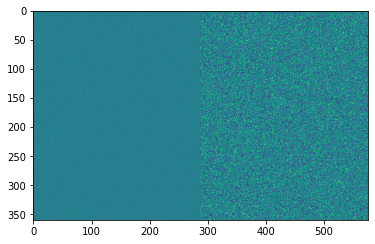

In [9]:
plt.imshow(trn_ds[-100][0].mean(0))

In [10]:
gt = []
preds = []
fold = 0

# Train - val split
trn_ds = DataV0(trn_df, True)
vld_ds = DataV0(val_df)

trn_dl = DataLoader(
    trn_ds,
    batch_size=CFG.bs,
    shuffle=True,
    num_workers=CFG.nw,
    pin_memory=True,
    drop_last=True,
)
vld_dl = DataLoader(
    vld_ds,
    batch_size=CFG.bs,
    shuffle=False,
    num_workers=CFG.nw,
    pin_memory=True,
)


custom_model =  LargeKernelModel(CFG)
custom_model.load_state_dict(torch.load('EXP_50_00_denoise_V5/EXP_50_00_denoise_V5_convnext_large_in22k_V_20_False_POS_0_9.pth'))
opt = torch.optim.AdamW(custom_model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
loss_func = BCEWithLogitsLossFlat()
warmup_steps = int(len(trn_dl) * int(CFG.warmup_pct * CFG.epoch))
total_steps = int(len(trn_dl) * CFG.epoch)
sched = get_linear_schedule_with_warmup(
    opt, num_warmup_steps=warmup_steps, num_training_steps=total_steps
)

fit_mixup(
    epochs=CFG.epoch,
    model=custom_model,
    train_dl=trn_dl,
    valid_dl=vld_dl,
    loss_fn=loss_func,
    opt=opt,
    val_df=val_df,
    metric=custom_auc_score,
    folder=CFG.folder,
    exp_name=f"{CFG.exp_name}_{fold}",
    device="cuda:0",
    sched=sched,
)
del custom_model
del trn_dl
del vld_dl
import gc

gc.collect()

16 1 31 255


epoch,train_loss,valid_loss,val_metric,roc_all,roc_50_100,roc_0_50,roc_0_40,roc_0_30,roc_0_20
0,0.451738,0.414461,0.851359,0.851359,0.851359,0.693384,0.600611,0.513395,0.390000
1,0.440942,0.421635,0.848298,0.848298,0.848298,0.685340,0.585149,0.503230,0.140667
2,0.430271,0.406279,0.863062,0.863062,0.863062,0.712734,0.621656,0.530502,0.269000
3,0.417043,0.412634,0.862040,0.862040,0.862040,0.709541,0.621948,0.527613,0.301000
4,0.406053,0.411230,0.862810,0.862810,0.862810,0.711496,0.621389,0.525905,0.257333


Better model found at epoch 0 with value: 0.8513591111111112.
Better model found at epoch 1 with value: 0.8482977777777778.
Better model found at epoch 2 with value: 0.863062.
Better model found at epoch 3 with value: 0.8620395555555557.
Better model found at epoch 4 with value: 0.8628102222222221.
Training done


101

In [ ]:
%debug

In [12]:
custom_model =  LargeKernelModel(CFG)
custom_model.load_state_dict(torch.load('EXP_50_00_denoise_V5_PSD/EXP_50_00_denoise_V5_PSD_convnext_large_in22k_V_20_False_POS_0_4.pth'))
custom_model.eval();
custom_model.cuda();


submit = pd.read_csv('../data/sample_submission.csv')
submit.columns = ['fn', 'target']
submit['fn'] = submit['fn'].apply(lambda x: Path('../data/test')/f'{x}_DENOISE_V5.pth')
submit.columns = ['id', 'target']

vld_ds = DataV0(submit)
vld_dl = DataLoader(
    vld_ds,
    batch_size=CFG.bs,
    shuffle=False,
    num_workers=CFG.nw,
    pin_memory=True,
)
out = []
with torch.no_grad():
    for x, y in tqdm(vld_dl):
        out.append(custom_model(x.cuda()).detach())

16 1 31 255


100%|████████████████████████████████████████████████████████████████████████████████| 307/307 [04:25<00:00,  1.16it/s]


In [13]:
#
pred = torch.sigmoid(torch.cat(out)).view(-1).cpu().numpy()

In [14]:
submit['target'] = pred

<AxesSubplot:ylabel='Frequency'>

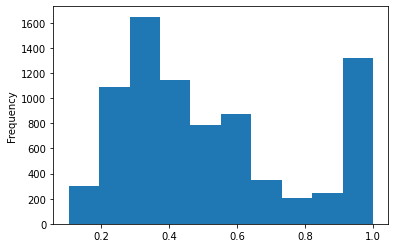

In [15]:
submit['target'].plot.hist()

In [16]:
submit['id'] = submit['id'].apply(lambda x: Path(x).stem)


In [17]:
submit['id'] = submit['id'].apply(lambda x: x.split('_')[0])
submit.to_csv('test_convnext_denoise_psd.csv', index=False)